# Microtask 6

## Aim of the task: 
The candidate can perform any analysis he or she wishes to. I have chosen to perform an analysis on the issues using pandas and matplotlib. The goals of the analysis are :

- The number of open issues vs closed issues
- The age of open issues
- The time taken to resolve issues

Fetching the data is the same as that of the other microtasks and hence is not mentioned here again, to avoid cluttering up the notebook. 

In [1]:
import json
import csv
import datetime
import pandas as pd
import matplotlib.pyplot as plt

## Getting the data
The data used for this microtask is the same as that used for the previous microtasks. Please check microtask 0 to see the cell output generated by running the commented script present two cells below this one. 
The cell below helps understand the data to be fetched, like the **owner**, the **repository names**, the **repository urls** and most importantly the **github authentication token**.  

**Make sure to fill in your token for the `auth_token` variable in the cell below.**

In [2]:
github_url = "https://github.com/"  # the github url domain: used for generating repo_urls
owner = "atom"
repos_used = ["language-java", "teletype"]
repo_urls = [github_url + owner + "/" + repo_used for repo_used in repos_used]
auth_token = "" # Please enter your github token here
file_name = owner + ".json" # file to which perceval stores data (a ../ is automatically added)

### Harnessing the power of jupyter notebooks 
The script in the cell below is a generalized way to create and populate a json file using perceval.  

The steps involved are simple: 
For each repository specified in the `repos_used` variable, fetch its git data, its pull_requests data and finally its issues data from the github api in that order and append them to the json file|. 

**Note**: it has been commented out to prevent an accidental overwrite of the progit.json file, present in the parent directory of our present directory. To work on more recent data, or to perform an analysis on a completely different set of repositories (make sure to change the variables in the cell above), please uncomment the snippet below and run the cell.

In [3]:
# for repo, repo_url in zip(repos_used, repo_urls):
#     print(repo, repo_url)

#     !perceval git --json-line $repo_url >> ../$file_name

#     !perceval github -t $auth_token --json-line --sleep-for-rate --category pull_request $owner $repo >> ../$file_name

#     !perceval github -t $auth_token --json-line --sleep-for-rate --category issue $owner $repo >> ../$file_name

# The Issue Class
To facilitate the analysis, the `Issue` class was created. 
Its structure is given below: 
    
variables:
- self.clean_issue_df (dataframe which stores the commits)

instance methods:
- \_\_init__(generator)   
    - parameters:   path_to_file  
    - returns: None  
        
private methods:
- \_str_to_dt_data: converts string dates to a datetime object with format: "%Y-%m-%d"
- \_clean_issue: takes a line from json file and converts to a dict
     

In [4]:
class Issue():   
    
    def __init__(self, path_to_file):

        # The dataframe mentioned in the above cell will be populated using the 
        # following list:  pd.DataFrame(list_name)
        clean_issue_list = list()

        with open(path_to_file, 'r') as raw_data:
            for line in raw_data:
                line = json.loads(line)

                if line['category'] == "issue" and "pull_request" not in line['data']:
                    clean_line = self._clean_issue(line)
                    clean_issue_list.append(clean_line)
                                            
            self.clean_issue_df = pd.DataFrame(clean_issue_list)


    def _clean_issue(self, line):
        repo_name = line['origin']
        line_data = line['data']
        cleaned_line ={
            'repo': repo_name,
            'hash': line_data['id'],
            'created_date': self._str_to_dt_data(line_data['created_at']),
            'current_status': line_data['state'], 
            'closed_at': None if line_data['state'] != "closed" else self._str_to_dt_data(line_data['closed_at']), 
            'last_updated': self._str_to_dt_data(line_data['updated_at']),
            'first_res_time': None if line_data["comments"] == 0 else self._str_to_dt_data(line_data["comments_data"][0]["created_at"])
        }

        return cleaned_line

    def _str_to_dt_data(self, date):
        datetimestr =  datetime.datetime.strptime(date, "%Y-%m-%dT%H:%M:%SZ").strftime("%Y-%m-%d")
        datetimeobj = datetime.datetime.strptime(datetimestr, "%Y-%m-%d")
        return datetimeobj    

## Creating an object
Lets use the Issue class created above and create the `clean_data` object, using the data retrieved by perceval. 

In [6]:
clean_data = Issue('../' + file_name)

# Analysis



## Number of closed and open issues
This is an important analysis. The number of issues created for a repository gives a slightly distorted version of how active and efficient the maintainers of that project are. Though a higher number of open issues often suggests low efficiency and a sense of untidiness, once must also check how active these open issues are, since issues are often the medium of discussion. 

The cell below houses a simple snippet. For each repository used for collecting data, a Series is created, based on the status of that issue. 

Next, a pie chart is plotted based on the number of "closed" and "open" issues. 

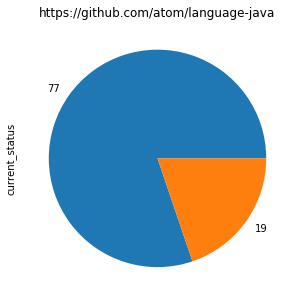

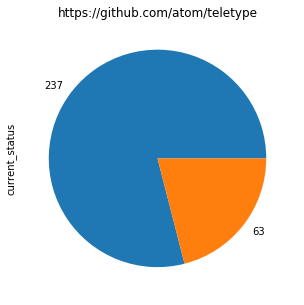

In [7]:
for repo_url in repo_urls:
    issue_status_series = clean_data.clean_issue_df["current_status"][clean_data.clean_issue_df['repo'] == repo_url]
    plt.figure()
    issue_status_series.value_counts().plot  \
    (
        kind='pie', 
        figsize=(5, 5), 
        title=repo_url,
        legend=False, 
        labels=issue_status_series.value_counts()
    )

## Age of open issues
As mentioned in the above analysis, open issues which are active give a high sense of activity and enthusiasm in that organization. Along the same lines, issues open for hundreds of days more often than not represent untidiness. 

The cell below shows a simple snippet which plots a bar chart for each repository considered for analysis. The y axis gives the number of days an open issue has been open, while the x axis, just gives an index of the issues in that repository and is of little importance for the purpose of the current analysis. 

Just like before, a Series is created, this time with elements of type timedelta, calculated by substracting the date of creation of a still-open issue from the current date. 

Next, the list `day` is created which containes the `days` instance variable of the timedelta objects in the `issue_status_series`. 

Following this, a simple bar graph is plotted, whose y axis is the number of days a particular issue has been open and whose x axis just contains an index for the issue (and like before, is not important here).

Also, for each repository, the average age of an open issue is calculated. 

Note: though it might seem that. since the data fetched by perceval is ordered, the bars of the graph should have strictly decreasing heights. For the most part, this is the case. The fact is that the data fetched has been ordered by "date of updation" and not "date of creation".

Average age of open issues in  https://github.com/atom/language-java  is(days):  339
Average age of open issues in  https://github.com/atom/teletype  is(days):  452


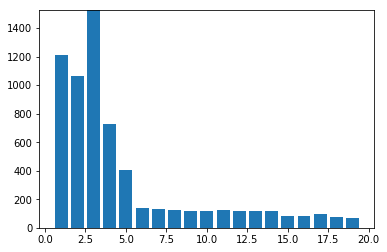

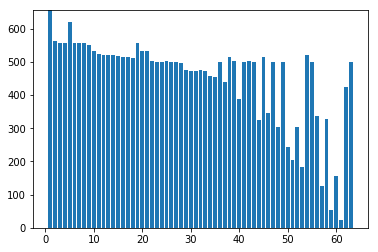

In [8]:
for repo_url in repo_urls:
    issue_status_series = datetime.datetime.now() - clean_data.clean_issue_df["created_date"][(clean_data.clean_issue_df["current_status"] == "open") & (clean_data.clean_issue_df['repo'] == repo_url)] 
    days = [x.days for x in issue_status_series]
    print("Average age of open issues in ", repo_url, " is(days): ", int(sum(days) / len(days)))
    plt.figure()
    plt.ylim([0, max(days)])
    plt.bar  \
    (
        x = range(1, len(days) +1),
        height=days, 
    )

## Time for issues to be resolved
Carrying on with the analysis, let us turn towards closed issues. The time taken for an issue to be resolved gives a crude measure of how active and how efficient the community surrounding that project is. I say crude because a shorter time of resolution could mean several things, like communities which quickly close issues without much discussion or communities with so many members that it is easy to stay on top of things, even with poor efficiency. 

The snippet below plots a bar graph based on the time it took to resolve issues. Thus, the y axis has time (in days). A separate plot is created for each repository analyzed, just like before. The average time for issue resolution per repository is also calculated, approximated to an integer. 


Average resolution time for  https://github.com/atom/language-java  is(days):  68

Average resolution time for  https://github.com/atom/teletype  is(days):  18


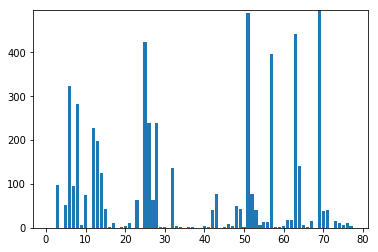

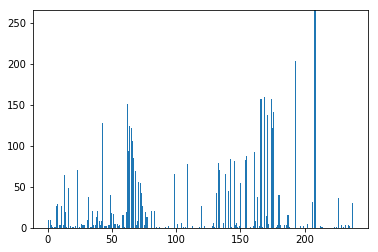

In [9]:
for repo_url in repo_urls:
    issue_status_series = clean_data.clean_issue_df["closed_at"][(clean_data.clean_issue_df["current_status"] == "closed") & (clean_data.clean_issue_df['repo'] == repo_url)] \
    - clean_data.clean_issue_df["created_date"][(clean_data.clean_issue_df["current_status"] == "closed") & (clean_data.clean_issue_df['repo'] == repo_url)] 
    print()
    days = [x.days for x in issue_status_series]
    print("Average resolution time for ", repo_url, " is(days): ", int(sum(days) / len(days)))
    plt.figure()
    plt.ylim([0, max(days)])
    plt.bar  \
    (
        x = range(1, len(days) +1),
        height=days, 
    )